<a href="https://colab.research.google.com/github/geo-tp/Keras-Colaboratory-Models/blob/main/image_ocr_Training_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detector Training

In [ ]:
!pip install image-ocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 813.9/813.9 kB 55.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.5 MB/s eta 0:00:00
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19579 sha256=9cfdce6c3ecdb52caaddbaef7438943d0378d60481f2a7ef2612f0a3e84ff966
  Stored in directory: /root/.cache/pip/wheels/f2/ed/dd/d3a556ad245ef9dc570c6bcd2f22886d17b0b408dd3bbb9ac3
Successfully built validators


## Import

In [ ]:
data_dir = '.'

import os
import math
import imgaug
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import tensorflow as tf

import image_ocr

## Dataset

In [ ]:
dataset = image_ocr.datasets.get_icdar_2013_detector_dataset(
    cache_dir='.',
    skip_illegible=False
)

Looking for ./icdar2013/Challenge2_Training_Task12_Images.zip
Looking for ./icdar2013/Challenge2_Training_Task2_GT.zip


## Image Generator

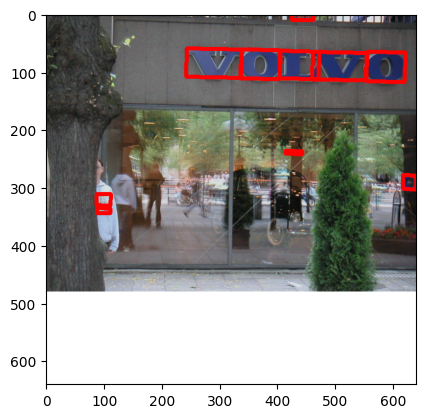

In [ ]:
train, validation = sklearn.model_selection.train_test_split(
    dataset, train_size=0.8, random_state=42
)
augmenter = imgaug.augmenters.Sequential([
    imgaug.augmenters.Affine(
      scale=(1.0, 1.2),
      rotate=(-5, 5)
    ),
    imgaug.augmenters.GaussianBlur(sigma=(0, 0.5)),
    imgaug.augmenters.Multiply((0.8, 1.2), per_channel=0.2)
])
generator_kwargs = {'width': 640, 'height': 640}
training_image_generator = image_ocr.datasets.get_detector_image_generator(
    labels=train,
    augmenter=augmenter,
    **generator_kwargs
)
validation_image_generator = image_ocr.datasets.get_detector_image_generator(
    labels=validation,
    **generator_kwargs
)

# Display an example
image, lines, confidence = next(training_image_generator)
canvas = image_ocr.tools.drawBoxes(image=image, boxes=lines, boxes_format='lines')
plt.imshow(canvas)

## Model Definition - Detector

In [ ]:
# Initalized with default weights
detector = image_ocr.detection.Detector()

Looking for /root/.keras-ocr/craft_mlt_25k.h5


## Training Generator

In [ ]:
batch_size = 1
training_generator, validation_generator = [
    detector.get_batch_generator(
        image_generator=image_generator, batch_size=batch_size
    ) for image_generator in
    [training_image_generator, validation_image_generator]
]

## Fit

In [ ]:
detector.model.fit(
    training_generator,
    steps_per_epoch=math.ceil(len(train) / batch_size),
    epochs=1000,
    workers=0,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=5),
        tf.keras.callbacks.CSVLogger(os.path.join(data_dir, 'detector_icdar2013.csv')),
        tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(data_dir, 'detector_icdar2013.h5'))
    ],
    validation_data=validation_generator,
    validation_steps=math.ceil(len(validation) / batch_size)
)